# **1. Instalación de librerias**

In [117]:
# Librerias generales
# Pandas
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Número máximo de filas a mostar
# Ranom seed
import numpy as np
np.random.seed(3301)

# Seaborn
import seaborn as sns

# Matplolib
%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
import unicodedata
import re
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [118]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [119]:
!pip install langdetect
from langdetect import detect #Para identificar idiomas de textos

In [120]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator #Libreria para realizar traduccion

# **2. Carga de datos**

In [172]:
db_location='/content/tipo2_entrenamiento_estudiantes.csv'
db_pred_location='/content/particion_prueba_estudiantes.csv'
dataFrame=pd.read_csv(db_location, sep=',', encoding = "UTF-8")
df_pred=pd.read_csv(db_pred_location, sep=',', encoding = "UTF-8")
data=dataFrame

# **3. Entendimiento**

Se va a realizar un manejo básico de lso datos para identificar diferentes estadisticas e información general acerca de las reseñas

In [122]:
data.shape

(7875, 2)

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [124]:
data

,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3
...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4
7871,"Fue una escapada de un día desde el complejo, ...",4
7872,La Plaza de la Revolución es un lugar emblemát...,3
7873,Es la segunda ocasión que me quedo en los cuar...,1


In [125]:
def moda_palabras(review):
    palabras = review.split()
    moda = Counter(palabras).most_common(1)
    return moda[0][0] if moda else None

In [126]:
textos = data.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Moda'] = [moda_palabras(i) for i in textos['Review']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos

,Review,Class,Conteo,Moda,Max,Min
0,Muy buena atención y aclaración de dudas por p...,5,252,de,20,0
1,Buen hotel si están obligados a estar cerca de...,3,297,de,13,1
2,"Es un lugar muy lindo para fotografías, visite...",5,104,Es,12,1
3,Abusados con la factura de alimentos siempre s...,3,422,y,14,1
4,Tuvimos un par de personas en el grupo que rea...,3,419,el,14,1
...,...,...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,113,el,11,2
7871,"Fue una escapada de un día desde el complejo, ...",4,261,de,12,2
7872,La Plaza de la Revolución es un lugar emblemát...,3,777,de,14,1
7873,Es la segunda ocasión que me quedo en los cuar...,1,651,que,12,0


Se evidencia que la moda de las palabras son stopwords que no ofrecen ningún tipo de información para el modelo. Por ello se van a eliminar en la preparación de datos.

In [127]:
#identificar idiomas
textos['idioma']=[detect(x) for x in textos['Review']]

In [128]:
textos

,Review,Class,Conteo,Moda,Max,Min,idioma
0,Muy buena atención y aclaración de dudas por p...,5,252,de,20,0,es
1,Buen hotel si están obligados a estar cerca de...,3,297,de,13,1,es
2,"Es un lugar muy lindo para fotografías, visite...",5,104,Es,12,1,es
3,Abusados con la factura de alimentos siempre s...,3,422,y,14,1,es
4,Tuvimos un par de personas en el grupo que rea...,3,419,el,14,1,es
...,...,...,...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,113,el,11,2,es
7871,"Fue una escapada de un día desde el complejo, ...",4,261,de,12,2,es
7872,La Plaza de la Revolución es un lugar emblemát...,3,777,de,14,1,es
7873,Es la segunda ocasión que me quedo en los cuar...,1,651,que,12,0,es


Se utilizo la libreria langdetect con el fin de identificar el idioma en el cual se encuentra la reseña. Esto con el fin de identificar si hay que realizar algun tratamiento con respecto a la traducción de ciertas reseñas.

In [129]:
idioma=textos[textos['idioma'] != 'es']
idioma

,Review,Class,Conteo,Moda,Max,Min,idioma
296,Excelente! Servicio estuvo excelente. \nLa com...,5,112,excelente.,12,2,pt
711,mas o menos estan mejor las de saltillo lñdkjv...,2,116,mas,76,1,sq
3749,First part of the tour was Rivera's actual hom...,2,351,of,10,2,en
4490,esta rico,4,9,esta,4,4,it
6518,A few months after ciudad perdida we keep on t...,5,394,a,14,1,en
6869,Cementerio Antiguo. Patrimonio Mundial. facil ...,5,102,Cementerio,10,2,it
7455,This university is unique around the world. Th...,5,213,is,12,2,en


Se evidencia que las reseñas se encuntran en otros idiomas diferentes al español. Aunque los que se identifica diferente a ingles se evidencia que estan en español.

In [130]:
col=['Class']
textos[col].describe()

,Class
count,7875.000000
mean,3.502603
std,1.320435
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Se verifico la columna de class con el fin de mirar que todos los valores dados esten dentro del rango especificado. Como se evidencia en la tabla esto es verdadero.

# **4. Preparación**

Para la preparación de los datos se van a realizar 3 etapas:

1. Traducción
2. Tokenización
3. Normalización

##**4.1 Traducción**

Por medio de la libreria googletrans se va a realizar una traducción de las reseñas que estan en ingles. Esto se debe a que las reseñas que en el entendimiento capto en otro idioma (como italiano) realmente se encontraban en español por lo que no es necesario realizar una traducción.

In [131]:
def traducir(row):
    review = row['Review']
    idioma = row['idioma']
    if idioma == 'en':
        translator = Translator()
        traduccion = translator.translate(review, src=idioma, dest='es')
        return traduccion.text
    else:
        return review

textos['Review'] = textos.apply(traducir, axis=1)

In [132]:
idioma=textos[textos['idioma'] != 'es']
idioma

,Review,Class,Conteo,Moda,Max,Min,idioma
296,Excelente! Servicio estuvo excelente. \nLa com...,5,112,excelente.,12,2,pt
711,mas o menos estan mejor las de saltillo lñdkjv...,2,116,mas,76,1,sq
3749,La primera parte de la gira fue el hogar real ...,2,351,of,10,2,en
4490,esta rico,4,9,esta,4,4,it
6518,"Unos meses después de Ciudad Perdida, seguimos...",5,394,a,14,1,en
6869,Cementerio Antiguo. Patrimonio Mundial. facil ...,5,102,Cementerio,10,2,it
7455,Esta universidad es única en todo el mundo.¡La...,5,213,is,12,2,en


In [133]:
cols=['Review','Class']
data=textos[cols]

##**4.2 Tokenización**

En este punto se va a dividir los textos en palabras individuales por lo que cada token va a representar una palabra de la reseña. Al dividir el texto en tokens, se simplifica la tarea de limpieza y normalización, ya que se puede aplicar cada paso de preprocesamiento de manera individual a cada token

In [134]:
data['words'] = [nltk.word_tokenize(x) for x in data['Review']]

<ipython-input-134-e2126c2407d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['words'] = [nltk.word_tokenize(x) for x in data['Review']]


In [135]:
cols=['words','Class']
data=data[cols]
data

,words,Class
0,"[Muy, buena, atención, y, aclaración, de, duda...",5
1,"[Buen, hotel, si, están, obligados, a, estar, ...",3
2,"[Es, un, lugar, muy, lindo, para, fotografías,...",5
3,"[Abusados, con, la, factura, de, alimentos, si...",3
4,"[Tuvimos, un, par, de, personas, en, el, grupo...",3
...,...,...
7870,"[Me, parece, buen, sistema, ,, agiliza, el, tr...",4
7871,"[Fue, una, escapada, de, un, día, desde, el, c...",4
7872,"[La, Plaza, de, la, Revolución, es, un, lugar,...",3
7873,"[Es, la, segunda, ocasión, que, me, quedo, en,...",1


##**4.3 Normalización**

Para este punto se va a realizar el siguiente tratamiento a cada uno de los tokens de las reseñas:
1. Convertir el texto a minuscula.
2. eliminar caracteres no alfabeticos.
3. Eliminar espacios en blanco adicionales.
4. Eliminar stopwords
5. Lematización
6. Normalización números

### **4.3.1 Convertir el texto a minuscula**

In [136]:
data['words'] = [[word.lower() for word in row] for row in data['words']]
data

,words,Class
0,"[muy, buena, atención, y, aclaración, de, duda...",5
1,"[buen, hotel, si, están, obligados, a, estar, ...",3
2,"[es, un, lugar, muy, lindo, para, fotografías,...",5
3,"[abusados, con, la, factura, de, alimentos, si...",3
4,"[tuvimos, un, par, de, personas, en, el, grupo...",3
...,...,...
7870,"[me, parece, buen, sistema, ,, agiliza, el, tr...",4
7871,"[fue, una, escapada, de, un, día, desde, el, c...",4
7872,"[la, plaza, de, la, revolución, es, un, lugar,...",3
7873,"[es, la, segunda, ocasión, que, me, quedo, en,...",1


### **4.3.2 Eliminar caracteres no alfabeticos**

In [137]:
data['words'] = data['words'].apply(lambda x: [re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ\s]', '', word) for word in x])
data

,words,Class
0,"[muy, buena, atención, y, aclaración, de, duda...",5
1,"[buen, hotel, si, están, obligados, a, estar, ...",3
2,"[es, un, lugar, muy, lindo, para, fotografías,...",5
3,"[abusados, con, la, factura, de, alimentos, si...",3
4,"[tuvimos, un, par, de, personas, en, el, grupo...",3
...,...,...
7870,"[me, parece, buen, sistema, , agiliza, el, tra...",4
7871,"[fue, una, escapada, de, un, día, desde, el, c...",4
7872,"[la, plaza, de, la, revolución, es, un, lugar,...",3
7873,"[es, la, segunda, ocasión, que, me, quedo, en,...",1


### **4.3.3 Eliminar espacios en blanco**

In [138]:
data['words'] = data['words'].apply(lambda x: [word for word in " ".join(x).split()])
data

,words,Class
0,"[muy, buena, atención, y, aclaración, de, duda...",5
1,"[buen, hotel, si, están, obligados, a, estar, ...",3
2,"[es, un, lugar, muy, lindo, para, fotografías,...",5
3,"[abusados, con, la, factura, de, alimentos, si...",3
4,"[tuvimos, un, par, de, personas, en, el, grupo...",3
...,...,...
7870,"[me, parece, buen, sistema, agiliza, el, trans...",4
7871,"[fue, una, escapada, de, un, día, desde, el, c...",4
7872,"[la, plaza, de, la, revolución, es, un, lugar,...",3
7873,"[es, la, segunda, ocasión, que, me, quedo, en,...",1


### **4.3.4 Eliminar stopwords**

In [139]:
stopwords_es = set(stopwords.words('spanish'))
data['words']=data['words'].apply(lambda x: [word for word in x if word.lower() not in stopwords_es])
data

,words,Class
0,"[buena, atención, aclaración, dudas, parte, se...",5
1,"[buen, hotel, si, obligados, cerca, centro, co...",3
2,"[lugar, lindo, fotografías, visiten, selina, m...",5
3,"[abusados, factura, alimentos, siempre, echan,...",3
4,"[par, personas, grupo, realmente, queríamos, c...",3
...,...,...
7870,"[parece, buen, sistema, agiliza, transporte, c...",4
7871,"[escapada, día, complejo, grupo, turistas, guí...",4
7872,"[plaza, revolución, lugar, emblemático, identi...",3
7873,"[segunda, ocasión, quedo, cuartos, area, jardí...",1


### **4.3.5 Lematización**

In [140]:
stemmer = SnowballStemmer('spanish')
data['words'] = data['words'].apply(lambda words: [stemmer.stem(word) for word in words])
data

,words,Class
0,"[buen, atencion, aclar, dud, part, señorit, ve...",5
1,"[buen, hotel, si, oblig, cerc, centr, convenci...",3
2,"[lug, lind, fotograf, visit, selin, music, viv...",5
3,"[abus, factur, aliment, siempr, echan, culp, v...",3
4,"[par, person, grup, realment, quer, com, cabri...",3
...,...,...
7870,"[parec, buen, sistem, agiliz, transport, conec...",4
7871,"[escap, dia, complej, grup, turist, gui, infor...",4
7872,"[plaz, revolu, lug, emblemat, identif, haban, ...",3
7873,"[segund, ocasion, qued, cuart, are, jardin, co...",1


### **4.3.6 Normalización números**

In [141]:
def normalize_numbers(words):
    new_words = []
    for word in words:
        if re.match(r'^-?\d+(?:\.\d+)?$', word):
            new_words.append('NUM')
        else:
            new_words.append(word)
    return new_words

In [142]:
data['words'] = data['words'].apply(normalize_numbers)
data

,words,Class
0,"[buen, atencion, aclar, dud, part, señorit, ve...",5
1,"[buen, hotel, si, oblig, cerc, centr, convenci...",3
2,"[lug, lind, fotograf, visit, selin, music, viv...",5
3,"[abus, factur, aliment, siempr, echan, culp, v...",3
4,"[par, person, grup, realment, quer, com, cabri...",3
...,...,...
7870,"[parec, buen, sistem, agiliz, transport, conec...",4
7871,"[escap, dia, complej, grup, turist, gui, infor...",4
7872,"[plaz, revolu, lug, emblemat, identif, haban, ...",3
7873,"[segund, ocasion, qued, cuart, are, jardin, co...",1


## **4.4 Bag of word**

El algoritmo bag of word convierte documentos de texto en vectores numéricos representando la frecuencia de ocurrencia de cada palabra en el documento. BoW es útil para la tarea de categorización de textos porque ignora el orden y la estructura gramatical del texto, centrándose únicamente en la presencia o ausencia de palabras clave. Esto permite una representación eficiente de los documentos y simplifica la tarea de clasificación al convertirla en un problema de asignación de vectores a categorías. Aunque BoW pierde información semántica y contextual, su simplicidad y eficacia lo hacen ampliamente utilizado en la clasificación de texto.

In [143]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([' '.join(words) for words in data['words']])
y = data['Class']

## **4.5 Entrenamiento y test**

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **5. Implementación de modelos**

## **5.1 Support vector machine (SVM)**

Su objetivo es encontrar un hiperplano en un espacio de características que maximice el margen entre las clases de datos, donde el margen es la distancia entre el hiperplano y los puntos de datos más cercanos de cada clase, conocidos como vectores de soporte. SVM funciona encontrando el hiperplano óptimo que separa las clases de datos utilizando una función de pérdida, generalmente la pérdida de bisagra, que penaliza las clasificaciones incorrectas.

In [145]:
svm=SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [146]:
y_pred = svm.predict(X_test)

In [147]:
cm = confusion_matrix(y_test, y_pred)

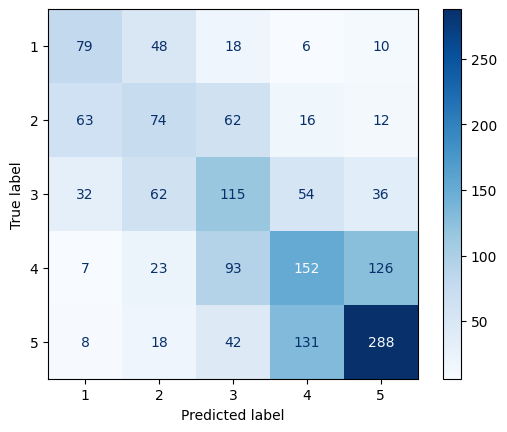

In [148]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [149]:
report_svm = classification_report(y_test, y_pred)
print("Test Report for SVM\n", report_svm)

Test Report for SVM
               precision    recall  f1-score   support

           1       0.42      0.49      0.45       161
           2       0.33      0.33      0.33       227
           3       0.35      0.38      0.37       299
           4       0.42      0.38      0.40       401
           5       0.61      0.59      0.60       487

    accuracy                           0.45      1575
   macro avg       0.43      0.43      0.43      1575
weighted avg       0.45      0.45      0.45      1575



Palabras seleccionadas para representar las reseñas

In [150]:
coeficientes = svm.coef_.toarray()[0]

In [151]:
vocabulario = vectorizer.get_feature_names_out()
coeficientes_palabras = pd.DataFrame({'Palabra': vocabulario, 'Coeficiente': coeficientes})

In [152]:
palabras_importancia = coeficientes_palabras.sort_values(by='Coeficiente', ascending=False)

In [153]:
palabras_importancia.head(10)

,Palabra,Coeficiente
12449,tibi,0.772680
3375,cuch,0.747528
13217,vidaademas,0.738099
5411,favor,0.727310
80,acab,0.693633
6566,ido,0.688011
9301,paisaj,0.682950
1023,asco,0.657932
2131,capacit,0.629000
11867,sombrer,0.628034


In [154]:
def encontrar_palabras_originales(raiz, palabras):
    palabras_originales = []
    for palabra in palabras:
        if raiz in palabra:
            palabras_originales.append(palabra)
    return palabras_originales

palabras_originales_por_raiz = {}
df_palabras=palabras_importancia.head(10)
for index, row in df_palabras.iterrows():
    raiz = row['Palabra']
    palabras_originales_por_raiz[raiz] = encontrar_palabras_originales(raiz, textos['Review'])

# Imprimir resultados
for raiz, palabras_originales in palabras_originales_por_raiz.items():
    print(f"Palabras originales para la raíz '{raiz}': {palabras_originales}")

Palabras originales para la raíz 'tibi': ['La presentación de alimentos es nula. Tazones de salsa manchados. Platos manchados por la parte de abajo con lo cual el mantel queda sucio. Los tazones de consone manchados de todo el borde. Tardan en servir alimentos. El chilpachole estaba tibio y no caliente.', 'Acudí con mi familia el fin de semana anterior a las elecciones en México. El precio es muy bueno en el todo incluido, la alberca del hotel es amplia y el agua es tibia, los cuartos tipo B son pequeños, no tienes acceso a las bebidas del frigobar, la comida a la carta es recomendable en el restaurante italiano y el menu mexicano, sólo que no toco mala experiencia con el mesero José en el italiano y la Sra que prepara los omelettes en el bufete por la mañana, además la Sra de recepcion Micaela que creo era la supervisora de recepcion, con muy mala actitud para atendernos al extendernos una noche...Cabe resaltar la buena atencion del mesero Alex en la alberca y en recepcion Diana.', 'U

## **5.2 Regresión logística**

In [155]:
lr= LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [156]:
y_pred = lr.predict(X_test)

In [157]:
cm = confusion_matrix(y_test, y_pred)

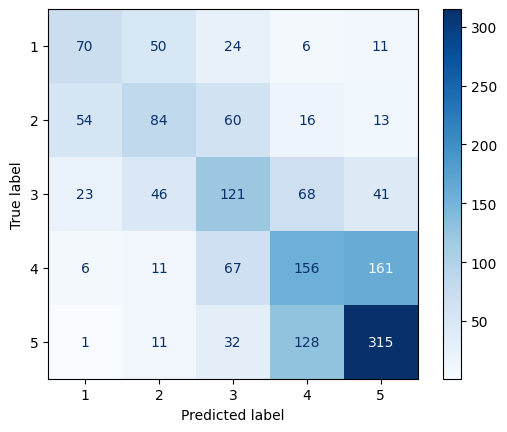

In [158]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [159]:
report_lr = classification_report(y_test, y_pred)
print("Test Report for Logistic Regression\n", report_lr)

Test Report for Logistic Regression
               precision    recall  f1-score   support

           1       0.45      0.43      0.44       161
           2       0.42      0.37      0.39       227
           3       0.40      0.40      0.40       299
           4       0.42      0.39      0.40       401
           5       0.58      0.65      0.61       487

    accuracy                           0.47      1575
   macro avg       0.45      0.45      0.45      1575
weighted avg       0.47      0.47      0.47      1575



In [160]:
coeficientes = lr.coef_[0]
palabras = vectorizer.get_feature_names_out()
palabra_coeficiente = dict(zip(palabras, coeficientes))
palabra_coeficiente_ordenado = sorted(palabra_coeficiente.items(), key=lambda x: abs(x[1]), reverse=True)
for palabra, coeficiente in palabra_coeficiente_ordenado[:10]:
    print(f"Palabra: {palabra}, Coeficiente: {coeficiente}")

Palabra: pesim, Coeficiente: 1.897743582355668
Palabra: horribl, Coeficiente: 1.6170762636286111
Palabra: peor, Coeficiente: 1.4736616184995641
Palabra: impresion, Coeficiente: -1.2003533547828307
Palabra: histori, Coeficiente: -1.1295141258054815
Palabra: desastr, Coeficiente: 1.1097837410984326
Palabra: engañ, Coeficiente: 1.1055339837566462
Palabra: lament, Coeficiente: 1.1030818933662014
Palabra: excelent, Coeficiente: -1.0903750926015852
Palabra: rot, Coeficiente: 1.082175571314105


Lo que representa el coeficiente es cuando impacto tiene una palabra en la probabilidad que una reseña sea clasificada a cierta clase.

Las palabras que tienen coeficientes positivos sugieren que si estas palabras están presentes en una reseña, el modelo es más propenso a clasificarla como una reseña con una calificación baja o negativa.

Por otro lado, las palabras que tienen coeficientes negativos significativos sugieren que si estas palabras están presentes en una reseña, el modelo es menos propenso a clasificarla como una reseña con una calificación baja o negativa, y podría indicar reseñas con calificaciones más altas.

## **5.3 Naive Bayes**

Naive Bayes es un algoritmo de aprendizaje supervisado basado en el teorema de Bayes. Se utiliza principalmente para la clasificación de datos. Su "naive" (ingenuo) viene de la suposición de independencia condicional entre las características, lo que significa que asume que todas las características son independientes entre sí dado el valor de la clase.

El algoritmo calcula la probabilidad de que una instancia pertenezca a una determinada clase basándose en la probabilidad condicional de las características dadas las clases. Luego, clasifica la instancia en la clase con la probabilidad más alta.

Es simple, eficiente y funciona bien en conjuntos de datos con muchas características, como el análisis de texto. Es especialmente útil cuando se tienen datos de alta dimensionalidad como el bag of words generado a partir de reseñas turísticas.

In [161]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [162]:
y_pred_nb = nb_classifier.predict(X_test)

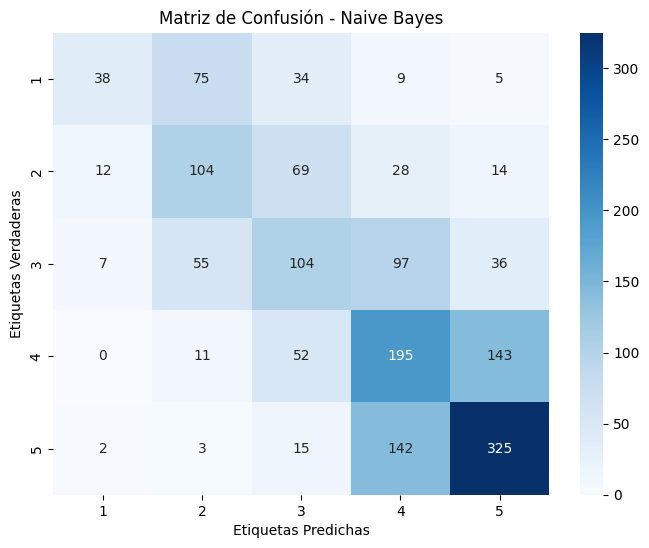

In [163]:
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Naive Bayes")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Verdaderas")
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5])
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5])
plt.show()

In [164]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy_nb)
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.48634920634920636
              precision    recall  f1-score   support

           1       0.64      0.24      0.35       161
           2       0.42      0.46      0.44       227
           3       0.38      0.35      0.36       299
           4       0.41      0.49      0.45       401
           5       0.62      0.67      0.64       487

    accuracy                           0.49      1575
   macro avg       0.50      0.44      0.45      1575
weighted avg       0.50      0.49      0.48      1575



In [165]:
vocabulario = vectorizer.vocabulary_
palabras_ordenadas = sorted(vocabulario, key=lambda palabra: vocabulario[palabra])
print("Palabras utilizadas por el modelo para la clasificación:")
print(palabras_ordenadas)

Palabras utilizadas por el modelo para la clasificación:
['aa', 'ab', 'abaceri', 'abad', 'abaj', 'abajomas', 'abajotambien', 'abalanz', 'abander', 'abandon', 'abarc', 'abarrot', 'abast', 'abastec', 'abedul', 'abej', 'abertur', 'abiert', 'abierton', 'abigail', 'abismal', 'abit', 'abofete', 'aboleng', 'abon', 'abond', 'abord', 'aborigen', 'abort', 'aboved', 'abra', 'abrac', 'abraham', 'abran', 'abras', 'abrasador', 'abraz', 'abrazogregor', 'abre', 'abren', 'abres', 'abrevader', 'abri', 'abriend', 'abriendol', 'abrier', 'abrieron', 'abries', 'abrig', 'abril', 'abrir', 'abrirl', 'abrirn', 'abrirs', 'abro', 'abrogat', 'abrum', 'abs', 'absid', 'absolut', 'absolutamemt', 'absolutomas', 'absorb', 'absten', 'abstract', 'absurd', 'abuch', 'abuel', 'abund', 'abundantehabi', 'abur', 'aburr', 'aburridoel', 'aburridor', 'aburrir', 'aburriri', 'aburrirt', 'abus', 'ac', 'aca', 'acab', 'acabari', 'academ', 'academi', 'acalor', 'acamp', 'acantil', 'acapulc', 'acarici', 'acarr', 'acarre', 'acas', 'acced'

In [166]:
log_probabilidades = nb_classifier.feature_log_prob_

vocabulario = vectorizer.get_feature_names_out()

palabras_log_probabilidad = [(palabra, log_probabilidad) for palabra, log_probabilidad in zip(vocabulario, log_probabilidades[1])]

palabras_log_probabilidad_ordenadas = sorted(palabras_log_probabilidad, key=lambda x: x[1], reverse=True)

print("Palabras más importantes y sus log probabilidades:")
for palabra, log_probabilidad in palabras_log_probabilidad_ordenadas[:10]:
    print(f"Palabra: {palabra}, Log Probabilidad: {log_probabilidad}")


Palabras más importantes y sus log probabilidades:
Palabra: hotel, Log Probabilidad: -4.265560502603546
Palabra: habit, Log Probabilidad: -4.469807420026466
Palabra: com, Log Probabilidad: -4.863032473240129
Palabra: buen, Log Probabilidad: -4.984471820099623
Palabra: mal, Log Probabilidad: -5.032300907789504
Palabra: servici, Log Probabilidad: -5.079507312359301
Palabra: si, Log Probabilidad: -5.082533033275838
Palabra: sol, Log Probabilidad: -5.215198999623931
Palabra: lug, Log Probabilidad: -5.222143471976742
Palabra: lleg, Log Probabilidad: -5.392687961579677


En un clasificador Naive Bayes multinomial, las log probabilidades representan el logaritmo de la probabilidad de observar una palabra dada una clase específica. Aunque las log probabilidades pueden ser negativas, esto simplemente indica que la probabilidad de la palabra dada esa clase es menor que 1. Las palabras con log probabilidades más negativas son más importantes para la clasificación de la clase, mientras que las menos negativas o positivas tienen menos influencia pero aún contribuyen al proceso de clasificación. Estas log probabilidades son útiles para identificar las palabras más relevantes en la clasificación y comprender cómo el modelo toma decisiones.

# **6. Modelo seleccionado**

Seleccionamos el modelo de regresión logística dado que es el que tiene mejores métricas.Procedemos a automatizar la aplicación del modelo con un pipeline.

In [167]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Tokenización
            tokens = word_tokenize(text)
            # Convertir a minúsculas, eliminar caracteres no alfabéticos, eliminar espacios en blanco y stopwords
            clean_tokens = [self.lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in self.stop_words]
            # Normalización de números
            clean_text = ' '.join(clean_tokens)
            preprocessed_texts.append(clean_text)
        return preprocessed_texts

pipeline = Pipeline([
    ('preprocesador', TextPreprocessor()),
    ('vectorizador', CountVectorizer()),  # Convertir texto en vectores de palabras
    ('regresion_logistica', LogisticRegression())  # Modelo de regresión logística
])

In [169]:
X_train, X_test, y_train, y_test = train_test_split(dataFrame['Review'], dataFrame['Class'], test_size=0.2, random_state=42)

In [170]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocesador', TextPreprocessor()),
                ('vectorizador', CountVectorizer()),
                ('regresion_logistica', LogisticRegression())])

# **7. Predicción de datos nuevos**

In [173]:
predicciones = pipeline.predict(df_pred['Review'])

In [174]:
df_pred['Class'] = predicciones

In [175]:
df_pred.to_csv('datos_clasificados.csv', index=False)
